## Fair-Universe | Starting kit (Physics)
***

#### Problem Setting:

arrival rate expectation of background events: $\beta$  
arrival rate expectation of signal events: $\mu \gamma$  
combined arrival rate expectation: $\nu = \beta + \mu \gamma$

$\mu$: parameter to be estimated ($0.9<\mu\leq1.1$)  

$\gamma$ and $\beta$ are fixed  
$\pi$ prior probability of signal for $\mu$ = 1  
$\nu_1$ expected number of test examples for $\mu$ = 1  
$z$: nuisance parameter  


#### Steps:
1. Draw $\mu$ uniformly between 0.9 and 1.1
2. Set systematiacs
    - Translation: 
        - Draw $z$ uniformly between -2 and 2 and choose z_angle randomly from 0, 45, 90
        - Draw $\alpha$ randomly chosen from 0, 45, 90 degrees (angle of translation)
4. Initialize $\nu_1$ = 10000
5. Initilaize $\pi$ = 0.01
6. Compute $\nu$ = $\nu_1 (\mu \pi + (1-\pi))$
7. Compute $\gamma$ = $\nu_1 \pi$
8. Compute $\beta$ = $\nu_1 (1-\pi)$
9. Compute $p_s$ = $\pi \mu /(\mu \pi + (1-\pi))$
10. Compute $p_b$  = $(1 - \pi)/(\mu \pi + (1-\pi))$
11. Draw $N \sim Poisson(\nu)$


Note: For train set, $\mu=1$

***

<img src="data-gen.png">

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sys import path
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime as dt

## Directories

In [2]:
model_dir = 'sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
data_generator_dir = "../Data_Generator"
visualize_dir = "visualize/"
params_dir = "params/"
augmentation_dir = "augmentation/"
training_dir = "training/"
optimization_dir = "optimization/"


path.append(model_dir) 
path.append(problem_dir)
path.append(score_dir)
path.append(data_generator_dir)
path.append(visualize_dir)
path.append(params_dir)
path.append(augmentation_dir)
path.append(training_dir)
path.append(optimization_dir)

In [3]:
from params import Params 
from setting import Setting 
from data_generator_physics import DataGenerator
from data_io import load_data, show_data_statistics, write
from visualize import (
    visualize_decicion_boundary,
    visualize_data,
    visualize_clocks,
    visualize_histogram
)
from model import Model
from trainer import Trainer
from optimizer import Optimizer
from metric import mse_metric, auc_metric, bac_metric

In [4]:
data_name = 'fair_universe_challenge'
data_dir = 'sample_data' 
number_of_samples = 100000

***
# 1 - Generate Params
***

### Define Systematics

In [5]:
systematics = [
    {
        "name": "Translation",
        "z_range": [-2, 2],
        "z_angles": [0, 45, 90]
    }
]

### Generate Data Gen Setting

In [6]:
data_gen_settings_train = []
data_gen_settings_test = []
data_gen_params_train = []
data_gen_params_test = []

for i in range(0,6):

    # Generate train params 
    data_gen_param_train = Params(
        pi=0.1,
        nu_1=number_of_samples,
        mu_range=[1.0, 1.0], 
        systematics=[],
        verbose=False
    )
    # Generate test params 
    data_gen_param_test = Params(
        pi=0.1,
        nu_1=number_of_samples,
        mu_range=[0.9, 1.1], 
        systematics=[],
        verbose=False
    )

    # Save params 
    data_gen_params_train.append(data_gen_param_train)
    data_gen_params_test.append(data_gen_param_test)

    # Generate setting from params for data generation
    data_gen_settings_train.append(Setting(case=i+1, params=data_gen_param_train).get_setting())
    data_gen_settings_test.append(Setting(case=i+1, params=data_gen_param_test).get_setting())


***
# 2 - Generate Data
***

In [7]:
start = dt.now()
for index, (train_settings, test_settings) in enumerate(zip(data_gen_settings_train, data_gen_settings_test)):

    
    # Train data
    data_gen_train = DataGenerator(settings_dict=train_settings)
    data_gen_train.generate_data()
    data_gen_train.save_data(directory="sample_data", data_type="train", file_index=index+1)

    # Test data
    data_gen_test = DataGenerator(settings_dict=test_settings)
    data_gen_test.generate_data()
    data_gen_test.save_data(directory="sample_data", data_type="test", file_index=index+1)

print(f"Elapsed Time: {dt.now() - start}")
  
    

Elapsed Time: 0:00:03.857488


In [8]:
train_sets = load_data(data_dir, "train")
test_sets = load_data(data_dir, "test")



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  sample_data/train/data
[*] labels dir :  sample_data/train/labels
[*] settings dir :  sample_data/train/settings
[+] data dir found
[+] labels dir found
[+] settings dir found
[+] 6 datsets found
---------------------------------
[+] Data loaded!
---------------------------------




###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  sample_data/test/data
[*] labels dir :  sample_data/test/labels
[*] settings dir :  sample_data/test/settings
[+] data dir found
[+] labels dir found
[+] settings dir found
[+] 6 datsets found
---------------------------------
[+] Data loaded!
---------------------------------




### Data Statistics

In [9]:
# show_data_statistics(train_sets, name="Train")

In [10]:
# show_data_statistics(test_sets, name="Test")

**Data Visualization**

In [11]:
# train_settings = [train_set["settings"] for train_set in train_sets]
# visualize_clocks(train_settings)

In [12]:
# for train_set, test_set in zip(train_sets, test_sets):
#     visualize_data(train_set, test_set)

***
# 3 - Optimize $\theta$
***

### Initialize caditate $\theta$

In [13]:
theta_candidates = np.arange(-10,3)
theta_candidates

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2])

### Get Train sets (one for each theta) and search for best $\theta$

In [14]:
start = dt.now()
data_gen_param_train = Params(
    pi=0.1,
    nu_1=number_of_samples,
    mu_range=[1.0, 1.0], 
    systematics=[],
    verbose=False
)
# Generate setting from params for data generation
data_gen_setting_train = Setting(case=i+1, params=data_gen_param_train).get_setting()

# Generate Data
data_gen_train = DataGenerator(settings_dict=data_gen_setting_train)
data_gen_train.generate_data()
train = data_gen_train.get_data()

# Optimize
optimizer = Optimizer(
    thetas = theta_candidates,
    train_set = train
)
optimizer.train()
optimizer.predict()
optimizer.compute_score()
best_theta_result = optimizer.get_best_theta()
print(f"Elapsed Time: {dt.now() - start}")

[*] Loading Model
[*] Training Model
[*] Get Predictions
[*] Compute Scores
[*] Return Best Theta
Elapsed Time: 0:00:00.174198


In [15]:
best_theta_result

{'theta': 0,
 'score': 0.0001404806063956581,
 'nu_roi': 11085,
 'beta_roi': 2202,
 'gamma_roi': 8883}

***
# 4 - Baselines
***

**Model Names and settings**

In [16]:
model_settings = [
    {
        "display_name": "NB",
        "model_name": "NB",
        "preprocessing" : False,
        "preprocessing_method" : "translation"
    }
]

**Train and Test**  

- Load Data
- Train Model
- Get Predictions
- Get Score
- Get Metric Scores
- Save Predictions
- Save Scores


In [17]:
start = dt.now()
trainer = Trainer(
    theta = best_theta_result["theta"],
    model_settings=model_settings,
    result_dir=result_dir,
    model_dir=model_dir,
    train_sets=train_sets,
    test_sets=test_sets,
    write=write
)
trainer.train()
train_results = trainer.get_result()
print(f"Elapsed Time: {dt.now() - start}")

############################################
### Training Program
############################################

--------------------------------------------
[*] Model : NB --- Preprocessing: False
--------------------------------------------

	Dataset : 1
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Compute Score
	[*] Saving Predictions and Scores

	Dataset : 2
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Compute Score
	[*] Saving Predictions and Scores

	Dataset : 3
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Compute Score
	[*] Saving Predictions and Scores

	Dataset : 4
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Compute Score
	[*] Saving Predictions and Scores

	Dataset : 5
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Compute Score
	[*] Saving Predictions and Scores

	Dataset : 6
	-------------

In [18]:
# One dataset train and test time
print(f"Train time : {train_results[0]['train_times'][0]}")
print(f"Test time : {train_results[0]['test_times'][0]}")

Train time : 0:00:00.011338
Test time : 0:00:00.022891


***
# 5 - Decision Boundary
***

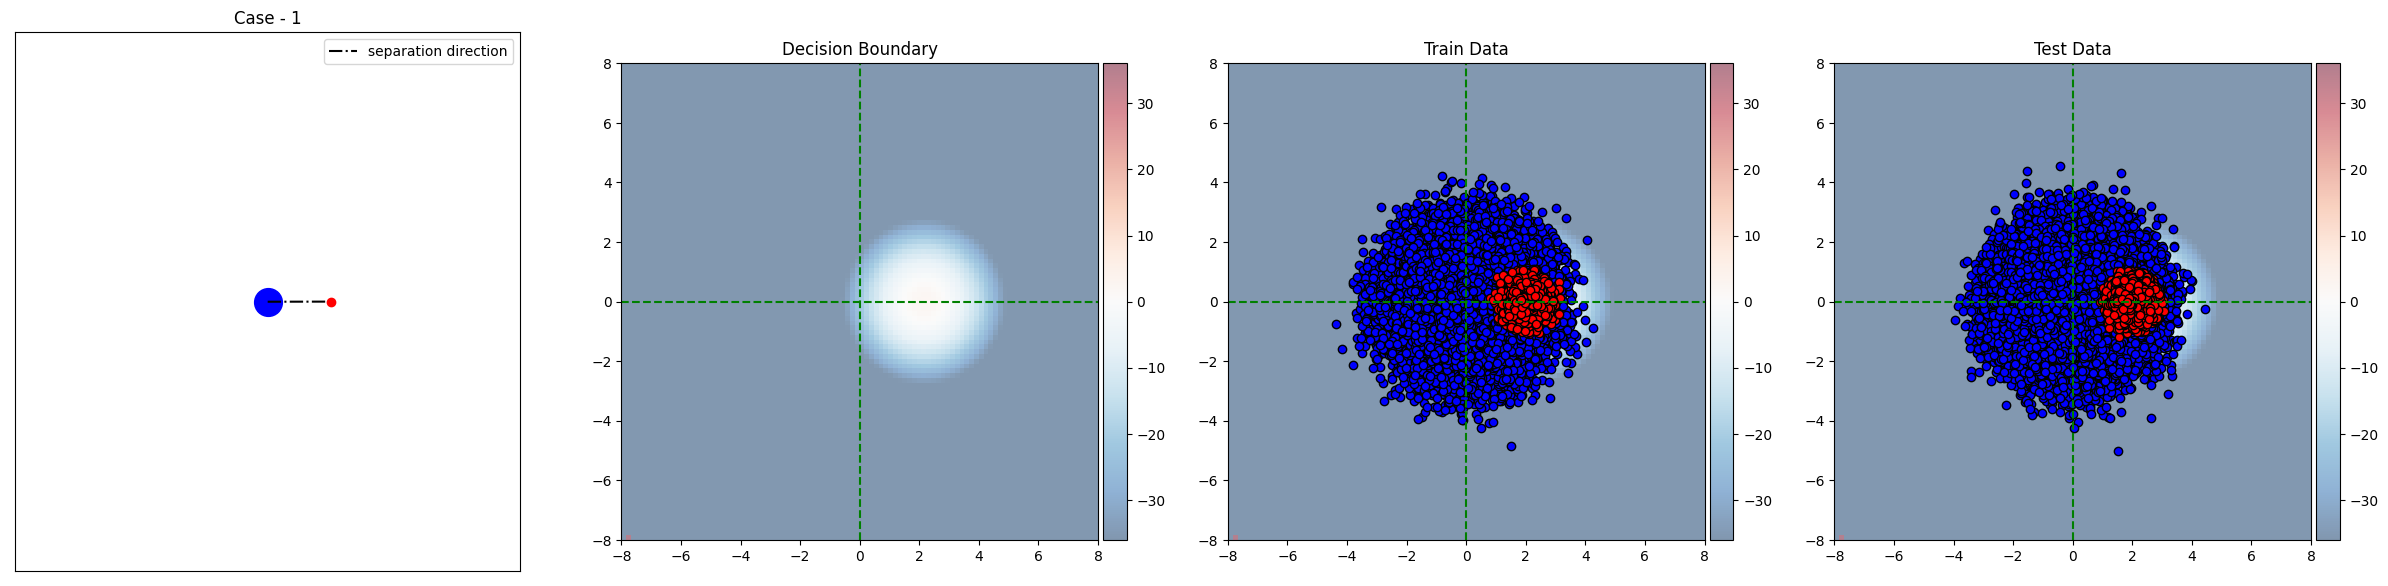

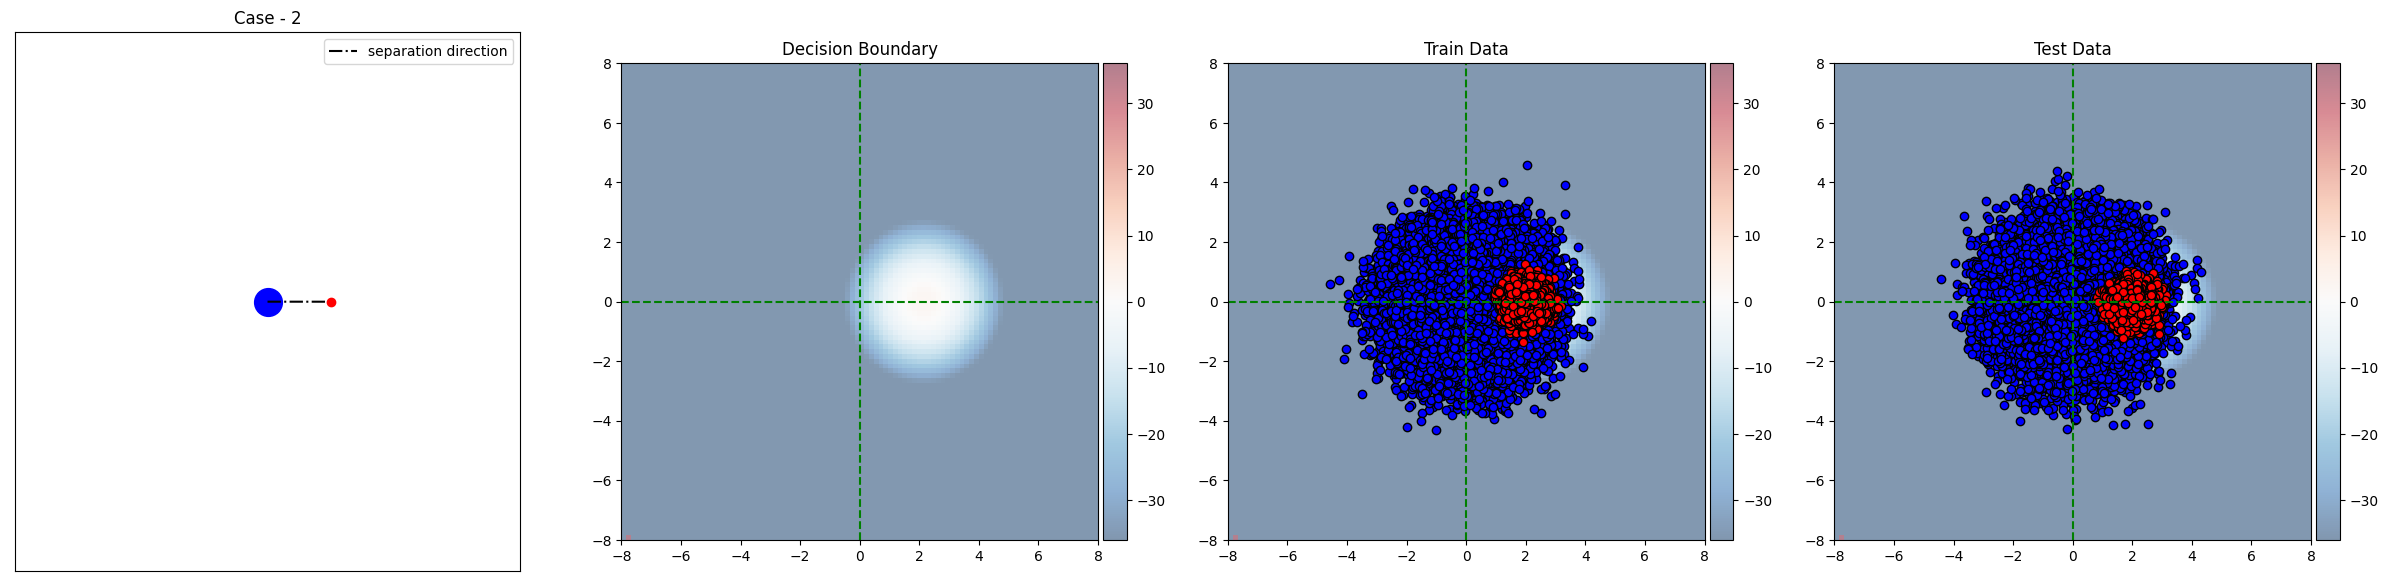

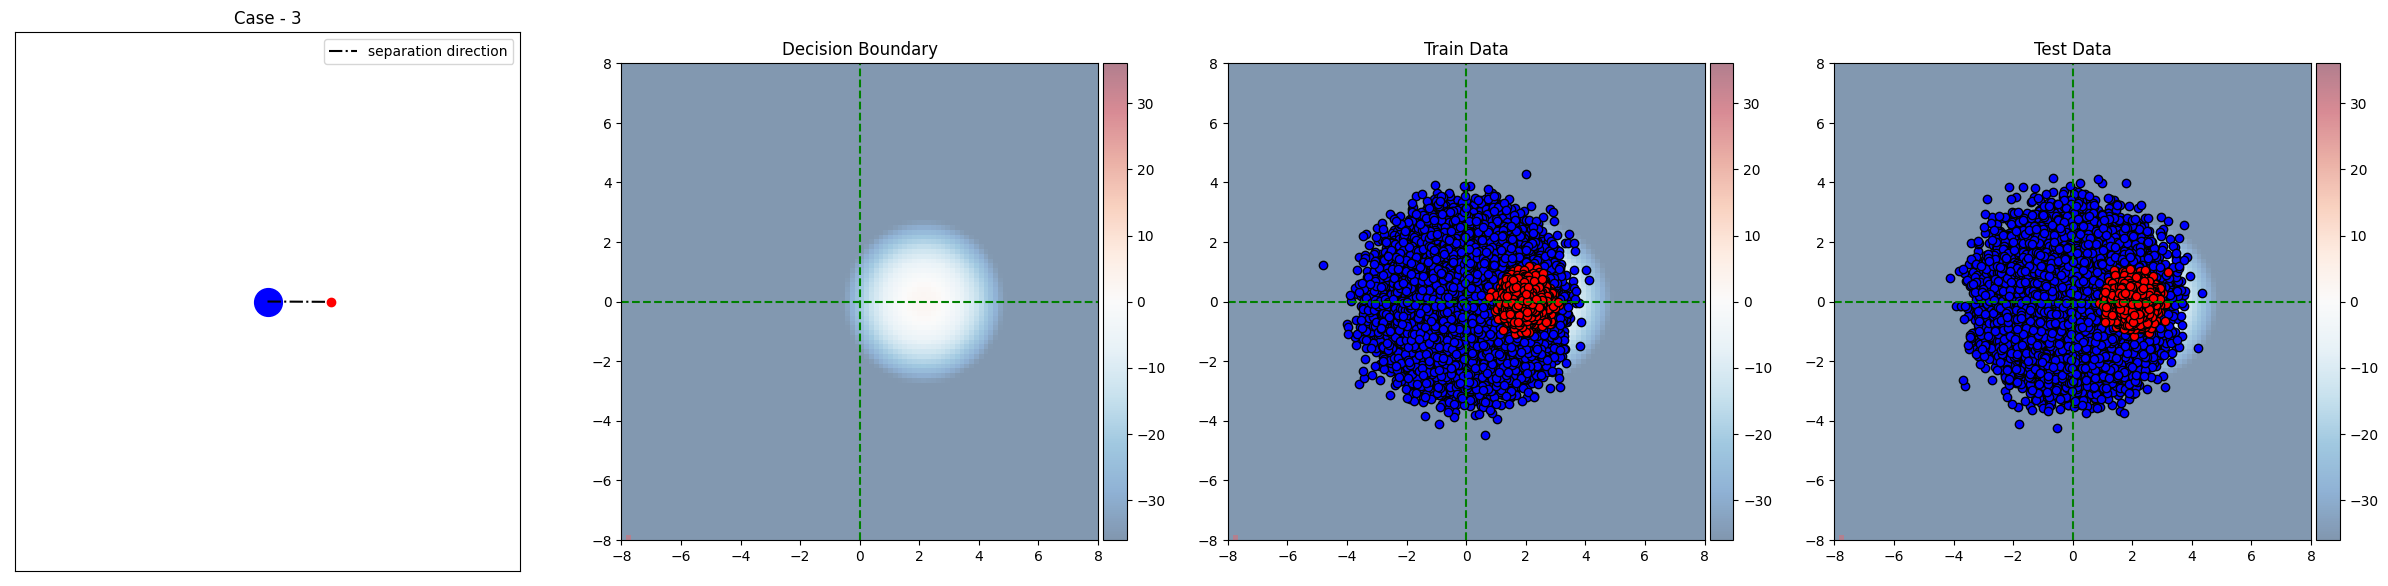

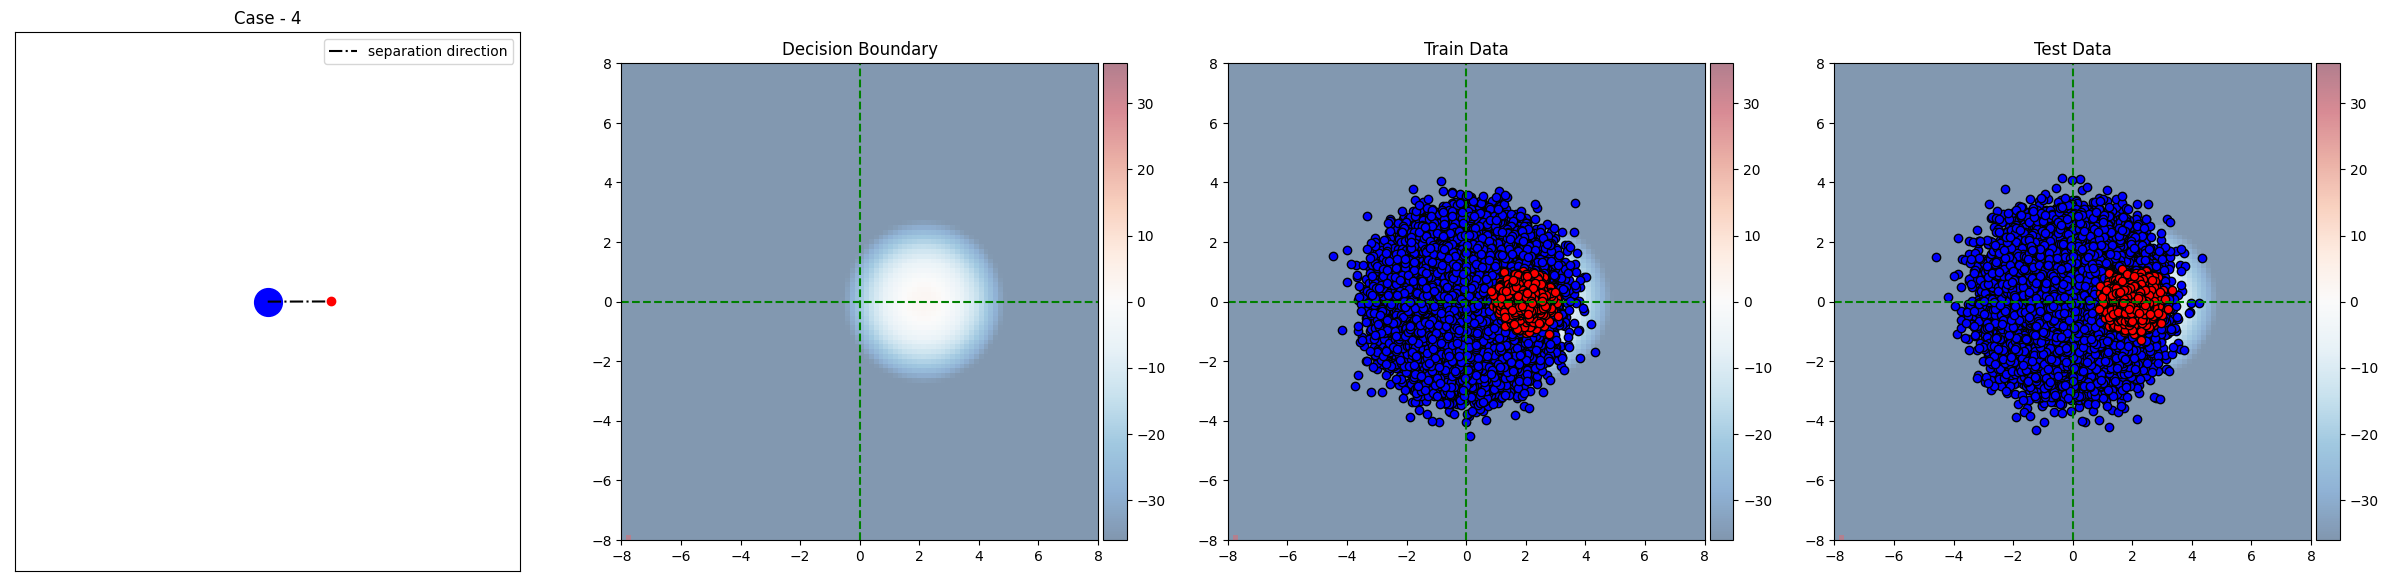

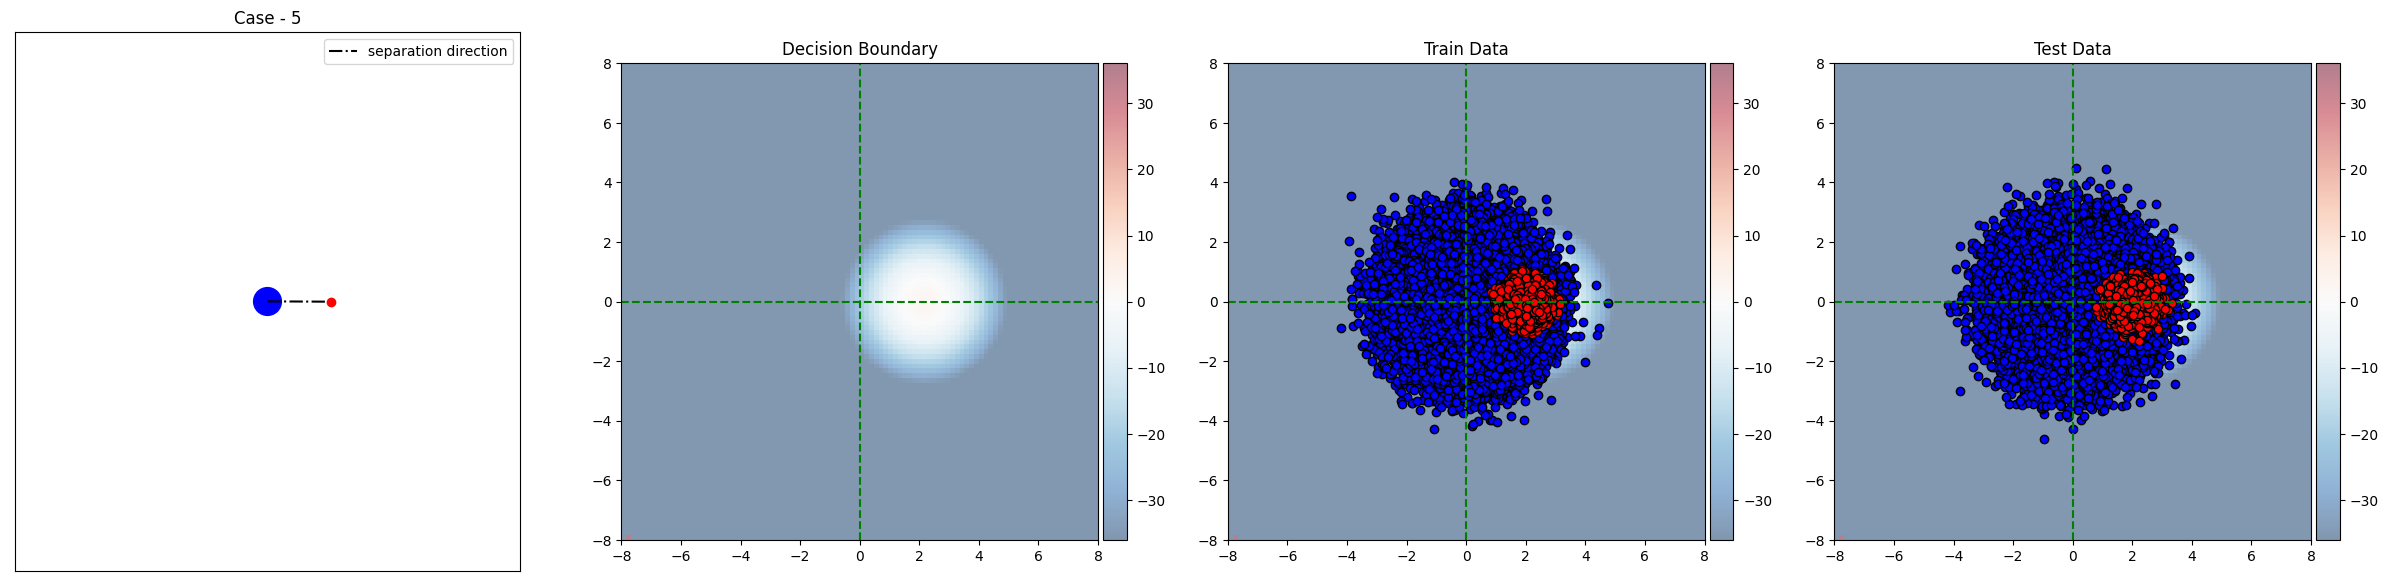

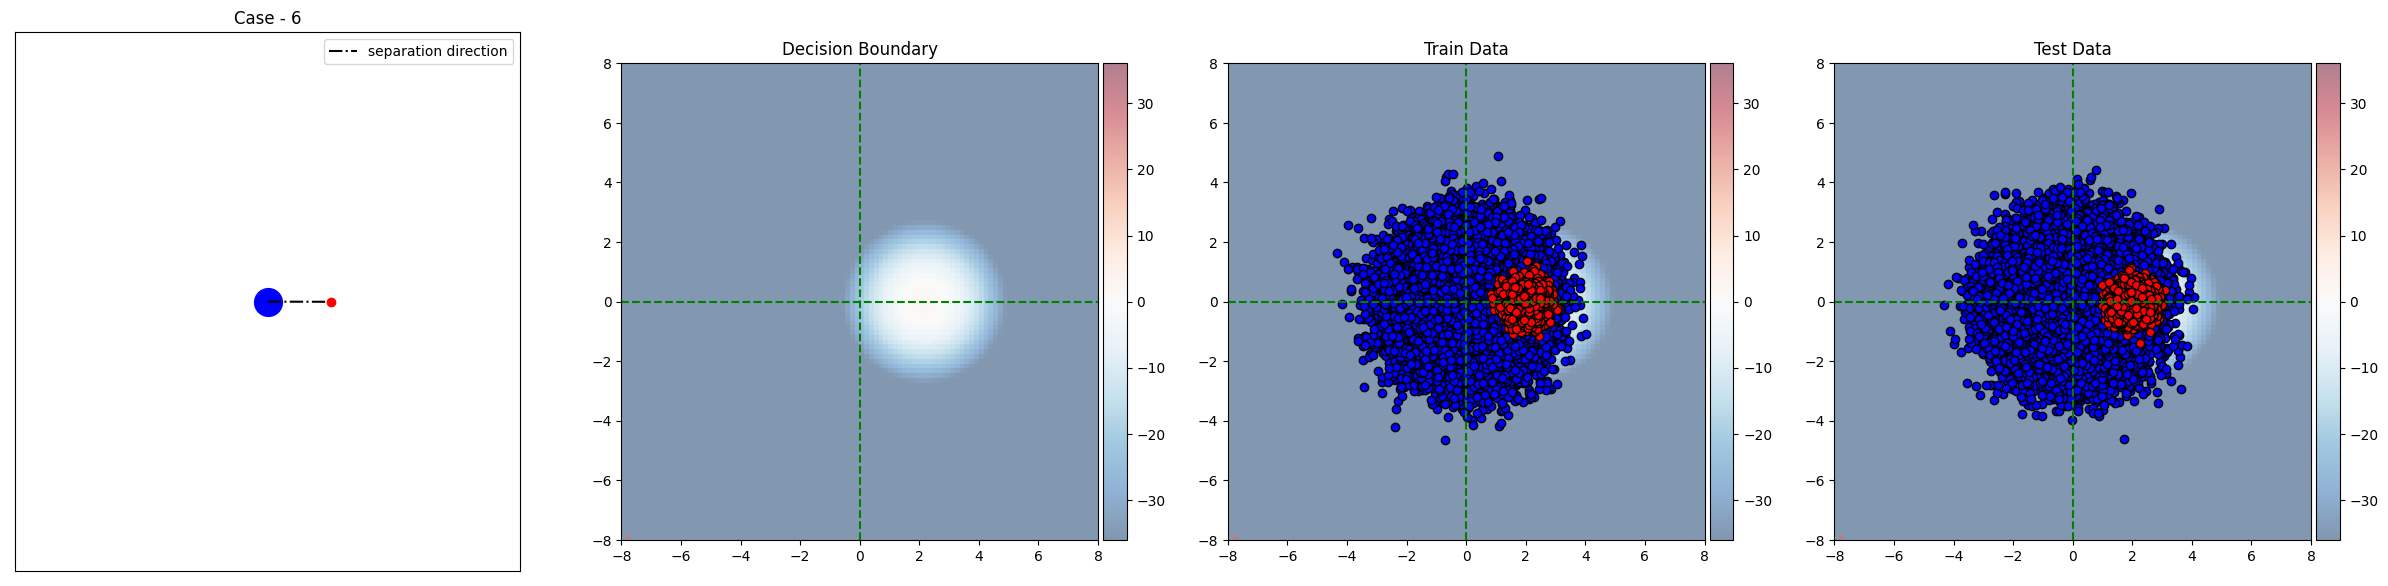

In [19]:
for model_s, result in zip(model_settings, train_results):
    visualize_decicion_boundary(model_s["display_name"], result, train_sets, test_sets)

***
# 6 - Histogram
***

Showing histogram for one dataset only (all datasets are generated in the same way with no systematics)

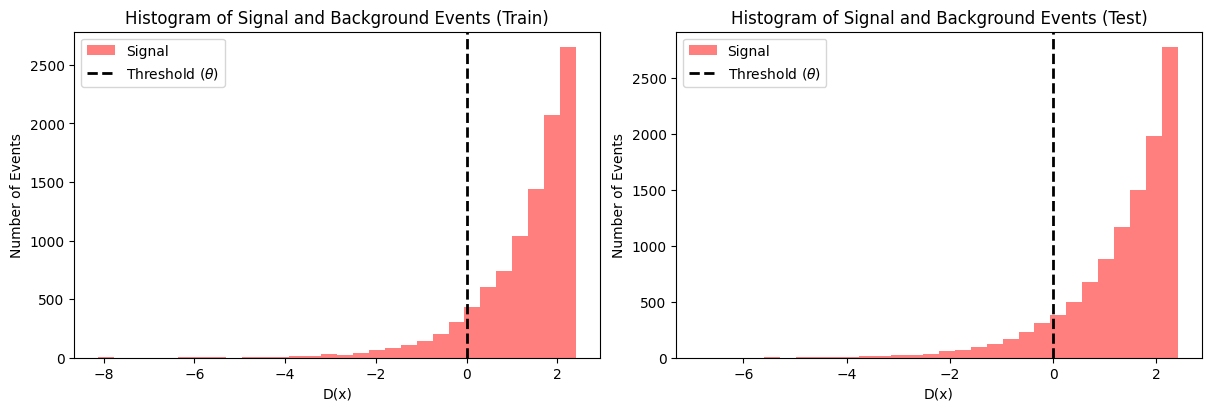

In [20]:
# Do not show Background histogram to visualize clearly the signal points distribution
visualize_histogram(
    Y_train=train_sets[0]["labels"],
    Y_test=test_sets[0]["labels"],
    Y_hat_train_decisions=train_results[0]["Y_hat_trains_decisions"][0],
    Y_hat_test_decisions=train_results[0]["Y_hat_tests_decisions"][0],
    theta=best_theta_result['theta'],
    show_bg=False,
)

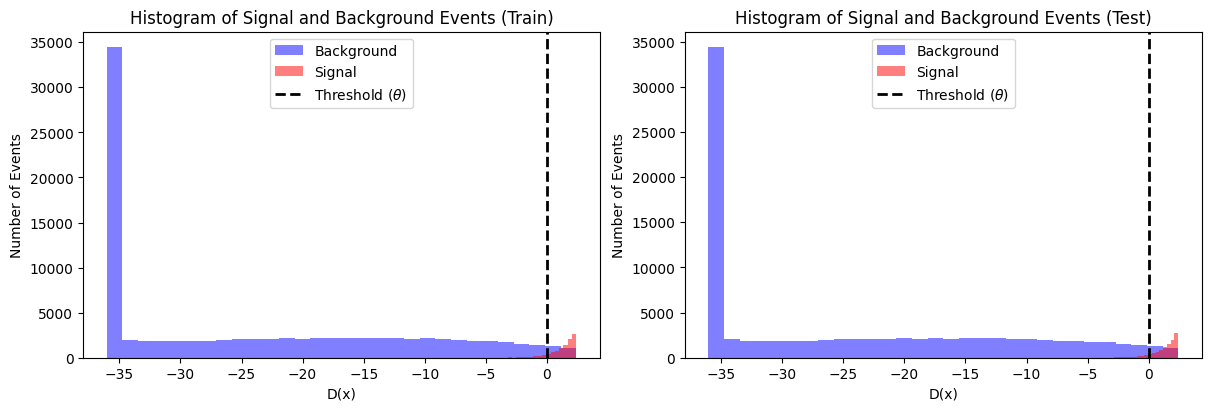

In [21]:
# This is the complete histogram with both signal and background data
visualize_histogram(
    Y_train=train_sets[0]["labels"],
    Y_test=test_sets[0]["labels"],
    Y_hat_train_decisions=train_results[0]["Y_hat_trains_decisions"][0],
    Y_hat_test_decisions=train_results[0]["Y_hat_tests_decisions"][0],
    theta=best_theta_result['theta'],
    show_bg=True,
)

***
# 7 - Results
We are using 100 test-sets
***

In [22]:
# train_results contains a list of results. each list item is result for one model setting

# get first result from train_results for GausssianNB
NB_result = train_results[0]

In [23]:
# estimated_mu consists of list of 6 items each corresponding to estimated mu for one dataset (total 6 datasets)
estimated_mu_train = NB_result["mu_hat_train"]
estimated_mu_test = NB_result["mu_hat_test"]
print("Train mean mu hat", np.mean(estimated_mu_train) )
print("Test mean mu hat", np.mean(estimated_mu_test) )

Train mean mu hat 1.0
Test mean mu hat 0.9799092188452239


### Scatter plot:
- x-axis : $\mu$
- y-axis: $\hat{\mu}$

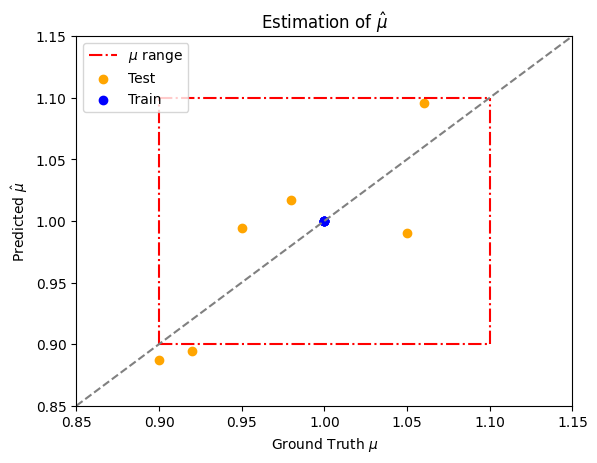

In [24]:
ground_mu_train = [p.get_mu() for p in data_gen_params_train]
ground_mu_test = [p.get_mu() for p in data_gen_params_test]
plt.hlines(y=0.9, xmin=0.9, xmax=1.1, linestyle='-.', color='r', label="$\mu$ range")
plt.hlines(y=1.1, xmin=0.9, xmax=1.1, linestyle='-.', color='r')
plt.vlines(x=0.9, ymin=0.9, ymax=1.1, linestyle='-.', color='r')
plt.vlines(x=1.1, ymin=0.9, ymax=1.1, linestyle='-.', color='r')
plt.plot([0.85,1.15], [0.85,1.15], linestyle='--', color="gray")
plt.scatter(ground_mu_test, estimated_mu_test, label="Test", color="orange")
plt.scatter(ground_mu_train, estimated_mu_train, label="Train", color="blue")


plt.xlabel("Ground Truth $\mu$")
plt.ylabel("Predicted $\hat{\mu}$")
plt.title("Estimation of $\hat{\mu}$")
plt.ylim(0.85,1.15)
plt.xlim(0.85,1.15)
plt.legend()
plt.show()

### Scatter plot:
- x-axis : $\mu$
- y-axis: $\Delta\mu = \mu - \hat{\mu}$

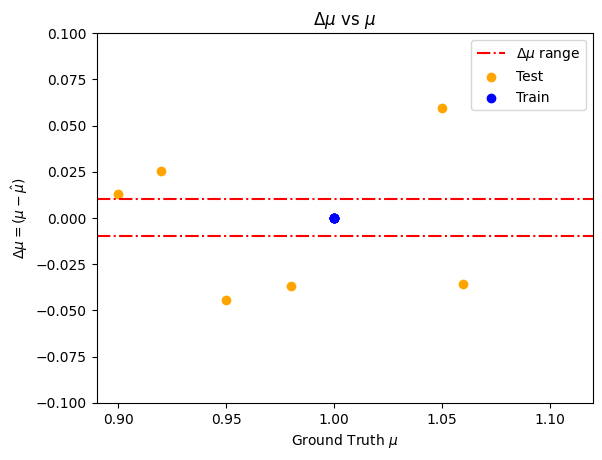

In [25]:
delta_mu_train = [mu.get_mu() - mu_hat for mu, mu_hat in zip(data_gen_params_train, estimated_mu_train)]
delta_mu_test = [mu.get_mu() - mu_hat for mu, mu_hat in zip(data_gen_params_test, estimated_mu_test)]
plt.axhline(y=0.01,linestyle='-.', color='r', label="$\Delta\mu$ range")
plt.axhline(y=-0.01,xmax=1.1, linestyle='-.', color='r')
plt.scatter(ground_mu_test, delta_mu_test, label="Test", color="orange")
plt.scatter(ground_mu_train, delta_mu_train, label="Train", color="blue")
plt.title("$\Delta{\mu}$ vs $\mu$")
plt.xlabel("Ground Truth $\mu$")
plt.ylabel("$\Delta{\mu} = (\mu - \hat{\mu})$")
plt.xlim(0.89,1.12)
plt.ylim(-0.1,0.1)
plt.legend()
plt.show()

### Scatter plot:
- x-axis : dataset
- y-axis: $\Delta\mu = \mu - \hat{\mu}$

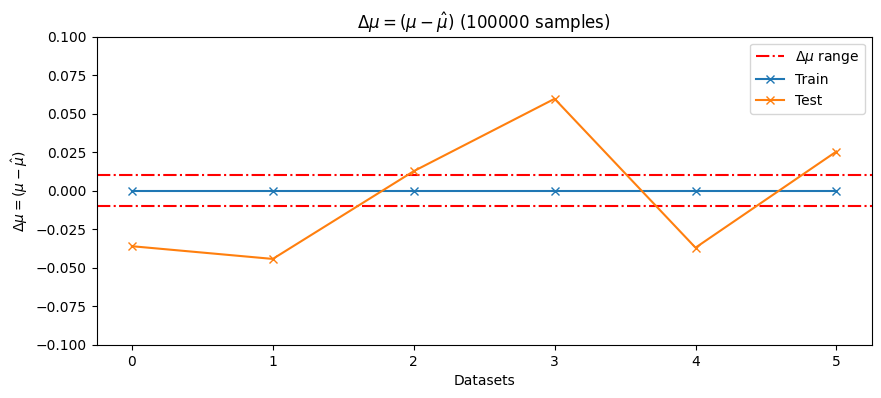

In [26]:
delta_mu_train = [mu.get_mu() - mu_hat for mu, mu_hat in zip(data_gen_params_train, estimated_mu_train)]
delta_mu_test = [mu.get_mu() - mu_hat for mu, mu_hat in zip(data_gen_params_test, estimated_mu_test)]
plt.figure(figsize=(10,4))
plt.axhline(y=0.01,linestyle='-.', color='r', label="$\Delta\mu$ range")
plt.axhline(y=-0.01,xmax=1.1, linestyle='-.', color='r')
plt.plot(delta_mu_train, marker="x", label="Train")
plt.plot(delta_mu_test, marker="x", label="Test")
plt.title("$\Delta{\mu} = (\mu - \hat{\mu})$ ("+str(number_of_samples)+" samples)")
plt.xlabel("Datasets")
plt.ylabel("$\Delta{\mu} = (\mu - \hat{\mu})$")
plt.ylim(-0.1,0.1)
plt.legend()
plt.show()